## Data prep

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import pickle
from sklearn.metrics import r2_score, classification_report

pd.set_option('mode.chained_assignment',None)

In [2]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=10, verbose=False, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 10
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.counter % 5 == 0:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return -r2

In [3]:
# Load full Data
df_full = pd.read_csv('data/processed/SimpleNNData.csv', index_col=0, parse_dates = [1])
y = df_full.time_to_reservation
df_full.drop(columns=['time_to_reservation', 'hour_index'], inplace=True)

# Load weather
Weather_Scale = pd.read_csv('data/processed/MinMaxWeather.csv', index_col=0)
weather_var = list(Weather_Scale.index)

# Load slicing
with open("data/processed/Sample_CC", "rb") as fp: 
    cc = pickle.load(fp)

df_full.head()

,time,leave_fuel,weekend,Time_Cos,Time_Sin,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,2019-10-31 00:00:11,86,0,1.000000,0.000800,6.0,3.4,0.0,0.0,1027.7,...,0,0,0,0,0,0,0,0,0,0
1,2019-10-31 00:01:04,84,0,0.999989,0.004654,6.0,3.4,0.0,0.0,1027.7,...,0,0,0,0,0,0,0,0,0,0
2,2019-10-31 00:01:14,99,0,0.999986,0.005381,6.0,3.4,0.0,0.0,1027.7,...,0,0,0,0,0,0,0,0,0,0
3,2019-10-31 00:02:06,52,0,0.999958,0.009163,6.0,3.4,0.0,0.0,1027.7,...,0,0,0,0,0,0,0,0,0,0
4,2019-10-31 00:03:33,47,0,0.999880,0.015489,6.0,3.4,0.0,0.0,1027.7,...,0,0,0,0,0,0,0,0,1,0


In [4]:
# For classification
Clas_Coef = dict(pd.concat([df_full.time.dt.hour.iloc[cc[0]],y[cc[0]]], axis = 1).groupby('time')['time_to_reservation'].mean()*2)
df_clas = pd.concat([df_full.time.dt.hour.iloc[cc[2]],y[cc[2]]], axis = 1)
df_clas['Cut'] = df_clas.time.map(dict(Clas_Coef))

In [5]:
# Common setting
batch_size = 512
num_epochs = 1501

## No Zones

In [6]:
df = df_full.drop(columns = list(df_full.filter(regex = 'lz').columns) + weather_var + ['dist_to_station','time'])
df['leave_fuel'] = df['leave_fuel']/100
df['degree'] = df['degree']/50
df.head()

,leave_fuel,weekend,Time_Cos,Time_Sin,degree,eng_118I,eng_COOPER,eng_I3,eng_X1
0,0.86,0,1.000000,0.000800,0.360118,0,1,0,0
1,0.84,0,0.999989,0.004654,0.197445,0,0,1,0
2,0.99,0,0.999986,0.005381,0.282942,0,0,0,1
3,0.52,0,0.999958,0.009163,0.046701,0,1,0,0
4,0.47,0,0.999880,0.015489,0.353928,0,1,0,0


In [7]:
X_train = torch.tensor(df.iloc[cc[0]].to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y[cc[0]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(df.iloc[cc[1]].to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y[cc[1]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(df.iloc[cc[2]].to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y[cc[2]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [8]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(9,256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64,1)
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x

net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=9, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 43777


Epoch  1: Train Loss -0.035159 , Valid Loss -0.052505 ,Train R2 0.060596, Valid R2 0.054802
Epoch 11: Train Loss -0.080685 , Valid Loss -0.088355 ,Train R2 0.098829, Valid R2 0.092056
Epoch 21: Train Loss -0.086549 , Valid Loss -0.090801 ,Train R2 0.101535, Valid R2 0.094382
Epoch 31: Train Loss -0.092916 , Valid Loss -0.100115 ,Train R2 0.111880, Valid R2 0.104187
Epoch 41: Train Loss -0.095483 , Valid Loss -0.101981 ,Train R2 0.114016, Valid R2 0.106147
EarlyStopping counter: 5 out of 20
Epoch 51: Train Loss -0.097242 , Valid Loss -0.105418 ,Train R2 0.117153, Valid R2 0.109527
Epoch 61: Train Loss -0.098993 , Valid Loss -0.104440 ,Train R2 0.116120, Valid R2 0.108126
Epoch 71: Train Loss -0.100622 , Valid Loss -0.105581 ,Train R2 0.117443, Valid R2 0.109472
EarlyStopping counter: 5 out of 20
Epoch 81: Train Loss -0.100580 , Valid Loss -0.106805 ,Train R2 0.119291, Valid R2 0.110696
EarlyStopping counter: 5 out of 20
Epoch 91: Train Loss -0.101956 , Valid Loss -0.106027 ,Train R2 0.1

Net(
  (seq): Sequential(
    (0): Linear(in_features=9, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)

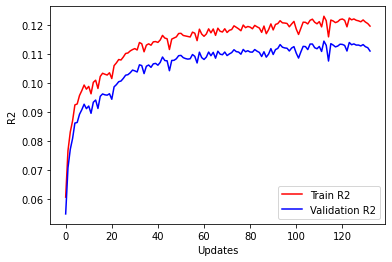

In [9]:
optimizer = optim.Adam(net.parameters(), lr=0.002, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

path = 'Results/SimpleNN/NoZones.pt'
early_stopping = EarlyStopping(patience=20, verbose=False, path = path)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

# Load best model
net.load_state_dict(torch.load(path))
net.eval()

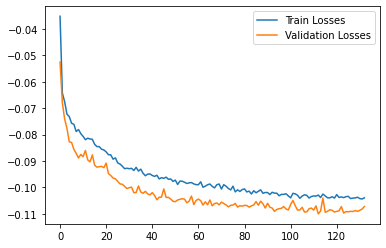

Max Val R2: 0.11445576399419277
Test R2: 0.11812473895033804


In [10]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

In [11]:
df_clas['Preds'] = net.forward(X_test).detach().numpy()[:,0]
print(classification_report(df_clas.time_to_reservation > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over']))

              precision    recall  f1-score   support

       Under       0.86      0.99      0.92     26743
        Over       0.52      0.04      0.08      4402

    accuracy                           0.86     31145
   macro avg       0.69      0.52      0.50     31145
weighted avg       0.81      0.86      0.80     31145



## Add Zones

In [12]:
df = df_full.drop(columns = weather_var + ['dist_to_station','time'])
df['leave_fuel'] = df['leave_fuel']/100
df['degree'] = df['degree']/50
df.head()

,leave_fuel,weekend,Time_Cos,Time_Sin,degree,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,0.86,0,1.000000,0.000800,0.360118,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.84,0,0.999989,0.004654,0.197445,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.99,0,0.999986,0.005381,0.282942,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0.52,0,0.999958,0.009163,0.046701,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.47,0,0.999880,0.015489,0.353928,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [13]:
X_train = torch.tensor(df.iloc[cc[0]].to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y[cc[0]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(df.iloc[cc[1]].to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y[cc[1]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(df.iloc[cc[2]].to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y[cc[2]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [14]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(265,256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64,1)
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x

net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=265, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 109313


Epoch  1: Train Loss 0.191040 , Valid Loss -0.049231 ,Train R2 0.057813, Valid R2 0.055277
Epoch 11: Train Loss -0.196812 , Valid Loss -0.205616 ,Train R2 0.224044, Valid R2 0.208721
Epoch 21: Train Loss -0.219387 , Valid Loss -0.217351 ,Train R2 0.243504, Valid R2 0.220529
Epoch 31: Train Loss -0.230819 , Valid Loss -0.221491 ,Train R2 0.254916, Valid R2 0.224788
Epoch 41: Train Loss -0.238277 , Valid Loss -0.223074 ,Train R2 0.263221, Valid R2 0.226550
EarlyStopping counter: 5 out of 20
Epoch 51: Train Loss -0.246568 , Valid Loss -0.223320 ,Train R2 0.269813, Valid R2 0.226841
EarlyStopping counter: 5 out of 20
Epoch 61: Train Loss -0.249147 , Valid Loss -0.223864 ,Train R2 0.275654, Valid R2 0.227534
EarlyStopping counter: 10 out of 20
EarlyStopping counter: 15 out of 20
Epoch 71: Train Loss -0.257316 , Valid Loss -0.223372 ,Train R2 0.280383, Valid R2 0.227107
EarlyStopping counter: 20 out of 20
Early stopping
Epoch 76: Train Loss -0.255940 , Valid Loss -0.223407 , Train R2 0.28250

Net(
  (seq): Sequential(
    (0): Linear(in_features=265, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)

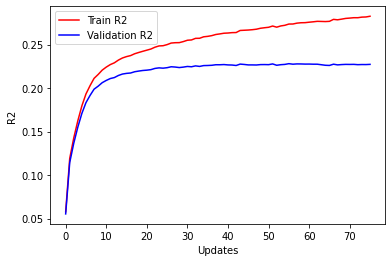

In [15]:
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

path = 'Results/SimpleNN/WithZones.pt'
early_stopping = EarlyStopping(patience=20, verbose=False, path = path)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

# Load best model
net.load_state_dict(torch.load(path))
net.eval()

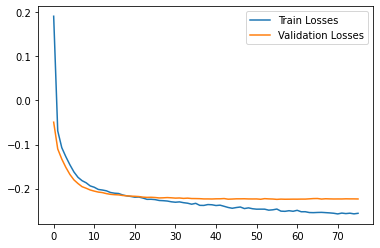

Max Val R2: 0.22797808271624354
Test R2: 0.23330461815619497


In [16]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

In [17]:
df_clas['Preds'] = net.forward(X_test).detach().numpy()[:,0]
print(classification_report(df_clas.time_to_reservation > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over']))

              precision    recall  f1-score   support

       Under       0.87      0.97      0.92     26743
        Over       0.48      0.15      0.23      4402

    accuracy                           0.86     31145
   macro avg       0.68      0.56      0.58     31145
weighted avg       0.82      0.86      0.82     31145



## Add Encoded zones

In [18]:
df = df_full.drop(columns = weather_var + ['dist_to_station','time'])
df['leave_fuel'] = df['leave_fuel']/100
df['degree'] = df['degree']/50
Mean_Zone_Times = dict(pd.DataFrame({'Zone': df.iloc[np.concatenate(cc[:2])].filter(regex = 'lz').idxmax(axis = 1).values, 'Time':y.iloc[np.concatenate(cc[:2])].values}).groupby('Zone').mean().squeeze())
df['Zone_E'] = df.filter(regex = 'lz').idxmax(1).map(Mean_Zone_Times)
df.drop(columns =  df.filter(regex = 'lz'), inplace = True)
df.head()

,leave_fuel,weekend,Time_Cos,Time_Sin,degree,eng_118I,eng_COOPER,eng_I3,eng_X1,Zone_E
0,0.86,0,1.000000,0.000800,0.360118,0,1,0,0,3.488767
1,0.84,0,0.999989,0.004654,0.197445,0,0,1,0,3.029264
2,0.99,0,0.999986,0.005381,0.282942,0,0,0,1,2.948682
3,0.52,0,0.999958,0.009163,0.046701,0,1,0,0,1.740973
4,0.47,0,0.999880,0.015489,0.353928,0,1,0,0,7.165938


In [19]:
X_train = torch.tensor(df.iloc[cc[0]].to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y[cc[0]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(df.iloc[cc[1]].to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y[cc[1]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(df.iloc[cc[2]].to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y[cc[2]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [20]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(10,256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64,1)
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x

net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 44033


Epoch  1: Train Loss 0.042543 , Valid Loss -0.130263 ,Train R2 0.132801, Valid R2 0.136257
Epoch 11: Train Loss -0.176306 , Valid Loss -0.190926 ,Train R2 0.195404, Valid R2 0.194799
EarlyStopping counter: 5 out of 20
Epoch 21: Train Loss -0.180192 , Valid Loss -0.191583 ,Train R2 0.196613, Valid R2 0.195337
EarlyStopping counter: 5 out of 20
Epoch 31: Train Loss -0.184045 , Valid Loss -0.192201 ,Train R2 0.197813, Valid R2 0.195958
Epoch 41: Train Loss -0.186745 , Valid Loss -0.193235 ,Train R2 0.199215, Valid R2 0.197062
EarlyStopping counter: 5 out of 20
Epoch 51: Train Loss -0.187398 , Valid Loss -0.193746 ,Train R2 0.200159, Valid R2 0.197534
Epoch 61: Train Loss -0.187709 , Valid Loss -0.194606 ,Train R2 0.201355, Valid R2 0.198394
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 5 out of 20
Epoch 71: Train Loss -0.190867 , Valid Loss -0.194909 ,Train R2 0.201645, Valid R2 0.198653
EarlyStopping counter: 5 out of 20
Epoch 81: Train Loss -0.191573 , Valid Loss -0.195843 ,

Net(
  (seq): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)

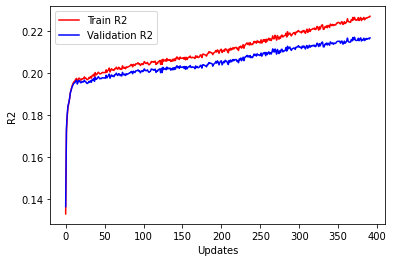

In [21]:
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay = 0.0000) #Chaged to Adam and learning + regulariztion rate set

num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

path = 'Results/SimpleNN/WithZonesEncoded.pt'
early_stopping = EarlyStopping(patience=20, verbose=False, path = path)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

# Load best model
net.load_state_dict(torch.load(path))
net.eval()

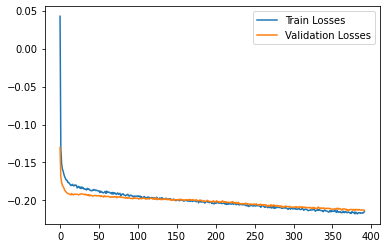

Max Val R2: 0.21697751395500187
Test R2: 0.2146354499716987


In [22]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

In [23]:
df_clas['Preds'] = net.forward(X_test).detach().numpy()[:,0]
print(classification_report(df_clas.time_to_reservation > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over']))

              precision    recall  f1-score   support

       Under       0.87      0.98      0.92     26743
        Over       0.48      0.10      0.17      4402

    accuracy                           0.86     31145
   macro avg       0.67      0.54      0.54     31145
weighted avg       0.81      0.86      0.82     31145



## Add Weather + Dist to station

In [24]:
df = df_full.drop(columns = list(df_full.filter(regex = 'lz').columns) + ['time'])
df['leave_fuel'] = df['leave_fuel']/100
df['degree'] = df['degree']/50
df['dist_to_station'] = df['dist_to_station']/5000
df[Weather_Scale.index] = (df[Weather_Scale.index] - Weather_Scale['Min'])/Weather_Scale['diff']
df.head()

,leave_fuel,weekend,Time_Cos,Time_Sin,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station,degree,eng_118I,eng_COOPER,eng_I3,eng_X1
0,0.86,0,1.000000,0.000800,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.062560,0.360118,0,1,0,0
1,0.84,0,0.999989,0.004654,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.115475,0.197445,0,0,1,0
2,0.99,0,0.999986,0.005381,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.078189,0.282942,0,0,0,1
3,0.52,0,0.999958,0.009163,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.084367,0.046701,0,1,0,0
4,0.47,0,0.999880,0.015489,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.192328,0.353928,0,1,0,0


In [25]:
X_train = torch.tensor(df.iloc[cc[0]].to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y[cc[0]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(df.iloc[cc[1]].to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y[cc[1]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(df.iloc[cc[2]].to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y[cc[2]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [26]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(17,256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64,1)
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x

net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=17, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 45825


Epoch  1: Train Loss 0.022756 , Valid Loss -0.087806 ,Train R2 0.096671, Valid R2 0.092522
Epoch 11: Train Loss -0.104659 , Valid Loss -0.110143 ,Train R2 0.123064, Valid R2 0.114595
Epoch 21: Train Loss -0.110577 , Valid Loss -0.113624 ,Train R2 0.127796, Valid R2 0.118142
Epoch 31: Train Loss -0.113777 , Valid Loss -0.116580 ,Train R2 0.131597, Valid R2 0.121145
Epoch 41: Train Loss -0.118776 , Valid Loss -0.118615 ,Train R2 0.134683, Valid R2 0.123087
Epoch 51: Train Loss -0.121420 , Valid Loss -0.122680 ,Train R2 0.139831, Valid R2 0.127436
Epoch 61: Train Loss -0.125962 , Valid Loss -0.124105 ,Train R2 0.142283, Valid R2 0.128868
Epoch 71: Train Loss -0.127980 , Valid Loss -0.126497 ,Train R2 0.145941, Valid R2 0.131368
EarlyStopping counter: 5 out of 20
Epoch 81: Train Loss -0.131168 , Valid Loss -0.128872 ,Train R2 0.149340, Valid R2 0.133805
EarlyStopping counter: 5 out of 20
Epoch 91: Train Loss -0.134719 , Valid Loss -0.129563 ,Train R2 0.151458, Valid R2 0.134419
Epoch 101: 

Net(
  (seq): Sequential(
    (0): Linear(in_features=17, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)

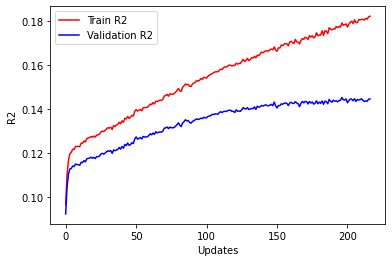

In [27]:
optimizer = optim.Adam(net.parameters(), lr=0.0003, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

path = 'Results/SimpleNN/WithWeather.pt'
early_stopping = EarlyStopping(patience=20, verbose=False, path = path)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

# Load best model
net.load_state_dict(torch.load(path))
net.eval()

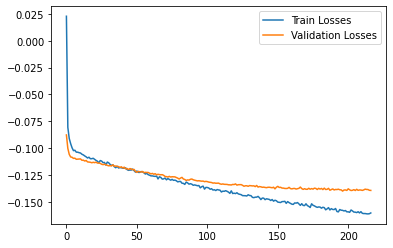

Max Val R2: 0.14528368114415524
Test R2: 0.15204595388965692


In [28]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

In [29]:
df_clas['Preds'] = net.forward(X_test).detach().numpy()[:,0]
print(classification_report(df_clas.time_to_reservation > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over']))

              precision    recall  f1-score   support

       Under       0.87      0.99      0.92     26743
        Over       0.49      0.07      0.12      4402

    accuracy                           0.86     31145
   macro avg       0.68      0.53      0.52     31145
weighted avg       0.81      0.86      0.81     31145



## With all

In [30]:
df = df_full.drop(columns = ['time'])
df['leave_fuel'] = df['leave_fuel']/100
df['degree'] = df['degree']/50
df['dist_to_station'] = df['dist_to_station']/5000
df[Weather_Scale.index] = (df[Weather_Scale.index] - Weather_Scale['Min'])/Weather_Scale['diff']
df.head()

,leave_fuel,weekend,Time_Cos,Time_Sin,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,0.86,0,1.000000,0.000800,0.196347,0.311927,0.0,0.0,0.829885,0.526957,...,0,0,0,0,0,0,0,0,0,0
1,0.84,0,0.999989,0.004654,0.196347,0.311927,0.0,0.0,0.829885,0.526957,...,0,0,0,0,0,0,0,0,0,0
2,0.99,0,0.999986,0.005381,0.196347,0.311927,0.0,0.0,0.829885,0.526957,...,0,0,0,0,0,0,0,0,0,0
3,0.52,0,0.999958,0.009163,0.196347,0.311927,0.0,0.0,0.829885,0.526957,...,0,0,0,0,0,0,0,0,0,0
4,0.47,0,0.999880,0.015489,0.196347,0.311927,0.0,0.0,0.829885,0.526957,...,0,0,0,0,0,0,0,0,1,0


In [31]:
X_train = torch.tensor(df.iloc[cc[0]].to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y[cc[0]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(df.iloc[cc[1]].to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y[cc[1]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(df.iloc[cc[2]].to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y[cc[2]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [32]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(273,256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64,1)
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x

net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=273, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 111361


Epoch  1: Train Loss 0.183369 , Valid Loss -0.049119 ,Train R2 0.056325, Valid R2 0.055319
Epoch 11: Train Loss -0.196132 , Valid Loss -0.201474 ,Train R2 0.221247, Valid R2 0.205052
Epoch 21: Train Loss -0.219670 , Valid Loss -0.215553 ,Train R2 0.244348, Valid R2 0.219087
Epoch 31: Train Loss -0.233193 , Valid Loss -0.220631 ,Train R2 0.258538, Valid R2 0.224264
Epoch 41: Train Loss -0.245488 , Valid Loss -0.222330 ,Train R2 0.269573, Valid R2 0.226101
Epoch 51: Train Loss -0.255325 , Valid Loss -0.222945 ,Train R2 0.279926, Valid R2 0.226775
EarlyStopping counter: 5 out of 20
Epoch 61: Train Loss -0.265521 , Valid Loss -0.221000 ,Train R2 0.287117, Valid R2 0.224932
EarlyStopping counter: 10 out of 20
EarlyStopping counter: 15 out of 20
Epoch 71: Train Loss -0.273017 , Valid Loss -0.222848 ,Train R2 0.298058, Valid R2 0.226963
EarlyStopping counter: 20 out of 20
Early stopping
Epoch 74: Train Loss -0.275078 , Valid Loss -0.221821 , Train R2 0.299077, Valid R2 0.225864


Net(
  (seq): Sequential(
    (0): Linear(in_features=273, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)

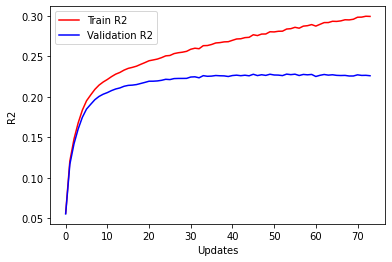

In [33]:
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

path = 'Results/SimpleNN/Full.pt'
early_stopping = EarlyStopping(patience=20, verbose=False, path = path)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

# Load best model
net.load_state_dict(torch.load(path))
net.eval()

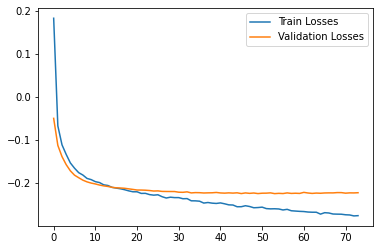

Max Val R2: 0.22786647760735135
Test R2: 0.2353472897977248


In [34]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

In [35]:
df_clas['Preds'] = net.forward(X_test).detach().numpy()[:,0]
print(classification_report(df_clas.time_to_reservation > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over']))

              precision    recall  f1-score   support

       Under       0.87      0.97      0.92     26743
        Over       0.47      0.15      0.23      4402

    accuracy                           0.86     31145
   macro avg       0.67      0.56      0.58     31145
weighted avg       0.82      0.86      0.82     31145



## With all and encoded zones

In [36]:
df = df_full.drop(columns = ['time'])
df['leave_fuel'] = df['leave_fuel']/100
df['degree'] = df['degree']/50
df['dist_to_station'] = df['dist_to_station']/5000
df[Weather_Scale.index] = (df[Weather_Scale.index] - Weather_Scale['Min'])/Weather_Scale['diff']
Mean_Zone_Times = dict(pd.DataFrame({'Zone': df.iloc[np.concatenate(cc[:2])].filter(regex = 'lz').idxmax(axis = 1).values, 'Time':y.iloc[np.concatenate(cc[:2])].values}).groupby('Zone').mean().squeeze())
df['Zone_E'] = df.filter(regex = 'lz').idxmax(1).map(Mean_Zone_Times)
df.drop(columns =  df.filter(regex = 'lz'), inplace = True)
df.head()

,leave_fuel,weekend,Time_Cos,Time_Sin,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station,degree,eng_118I,eng_COOPER,eng_I3,eng_X1,Zone_E
0,0.86,0,1.000000,0.000800,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.062560,0.360118,0,1,0,0,3.488767
1,0.84,0,0.999989,0.004654,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.115475,0.197445,0,0,1,0,3.029264
2,0.99,0,0.999986,0.005381,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.078189,0.282942,0,0,0,1,2.948682
3,0.52,0,0.999958,0.009163,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.084367,0.046701,0,1,0,0,1.740973
4,0.47,0,0.999880,0.015489,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.192328,0.353928,0,1,0,0,7.165938


In [37]:
X_train = torch.tensor(df.iloc[cc[0]].to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y[cc[0]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(df.iloc[cc[1]].to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y[cc[1]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(df.iloc[cc[2]].to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y[cc[2]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [38]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(18,256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64,1)
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x

net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=18, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 46081


Epoch  1: Train Loss 0.007587 , Valid Loss -0.141264 ,Train R2 0.143717, Valid R2 0.146956
Epoch 11: Train Loss -0.172758 , Valid Loss -0.186438 ,Train R2 0.192017, Valid R2 0.190390
Epoch 21: Train Loss -0.183990 , Valid Loss -0.190122 ,Train R2 0.196678, Valid R2 0.194103
Epoch 31: Train Loss -0.188247 , Valid Loss -0.191841 ,Train R2 0.199023, Valid R2 0.195835
EarlyStopping counter: 5 out of 20
Epoch 41: Train Loss -0.188168 , Valid Loss -0.194483 ,Train R2 0.202192, Valid R2 0.198534
EarlyStopping counter: 5 out of 20
Epoch 51: Train Loss -0.190426 , Valid Loss -0.195373 ,Train R2 0.203475, Valid R2 0.199369
Epoch 61: Train Loss -0.192899 , Valid Loss -0.194811 ,Train R2 0.203427, Valid R2 0.198712
Epoch 71: Train Loss -0.195092 , Valid Loss -0.197442 ,Train R2 0.206617, Valid R2 0.201449
Epoch 81: Train Loss -0.197696 , Valid Loss -0.198438 ,Train R2 0.207907, Valid R2 0.202470
Epoch 91: Train Loss -0.199642 , Valid Loss -0.198664 ,Train R2 0.208459, Valid R2 0.202658
EarlyStoppi

Net(
  (seq): Sequential(
    (0): Linear(in_features=18, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)

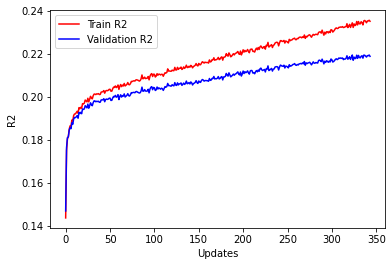

In [39]:
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

path = 'Results/SimpleNN/FullEncoded.pt'
early_stopping = EarlyStopping(patience=20, verbose=False, path = path)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

# Load best model
net.load_state_dict(torch.load(path))
net.eval()

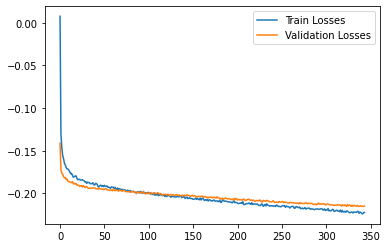

Max Val R2: 0.21940854106216545
Test R2: 0.2180112261408087


In [40]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

In [41]:
df_clas['Preds'] = net.forward(X_test).detach().numpy()[:,0]
print(classification_report(df_clas.time_to_reservation > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over']))

              precision    recall  f1-score   support

       Under       0.87      0.98      0.92     26743
        Over       0.46      0.11      0.18      4402

    accuracy                           0.86     31145
   macro avg       0.66      0.55      0.55     31145
weighted avg       0.81      0.86      0.82     31145

